In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pywt # Esta libreria es la que maneja las transformadas
import pywt.data
from scipy import signal
from scipy.ndimage import gaussian_filter

In [12]:
# Cargar imagen y simular desenfoque
original = pywt.data.camera()

In [13]:
# Simular desenfoque con un kernel gaussiano
kernel_size = 15
sigma = 3
blur_kernel = np.zeros((kernel_size, kernel_size))
for i in range(kernel_size):
    for j in range(kernel_size):
        dist = np.sqrt((i - kernel_size//2)**2 + (j - kernel_size//2)**2)
        blur_kernel[i, j] = np.exp(-dist**2 / (2*sigma**2))
blur_kernel = blur_kernel / np.sum(blur_kernel)

In [14]:
# Aplicar el desenfoque a la imagen original
blurred = signal.convolve2d(original, blur_kernel, mode='same', boundary='wrap')

In [15]:
# Función de soft thresholding para los coeficientes wavelet
def soft_threshold(x, threshold):
    return np.sign(x) * np.maximum(np.abs(x) - threshold, 0)

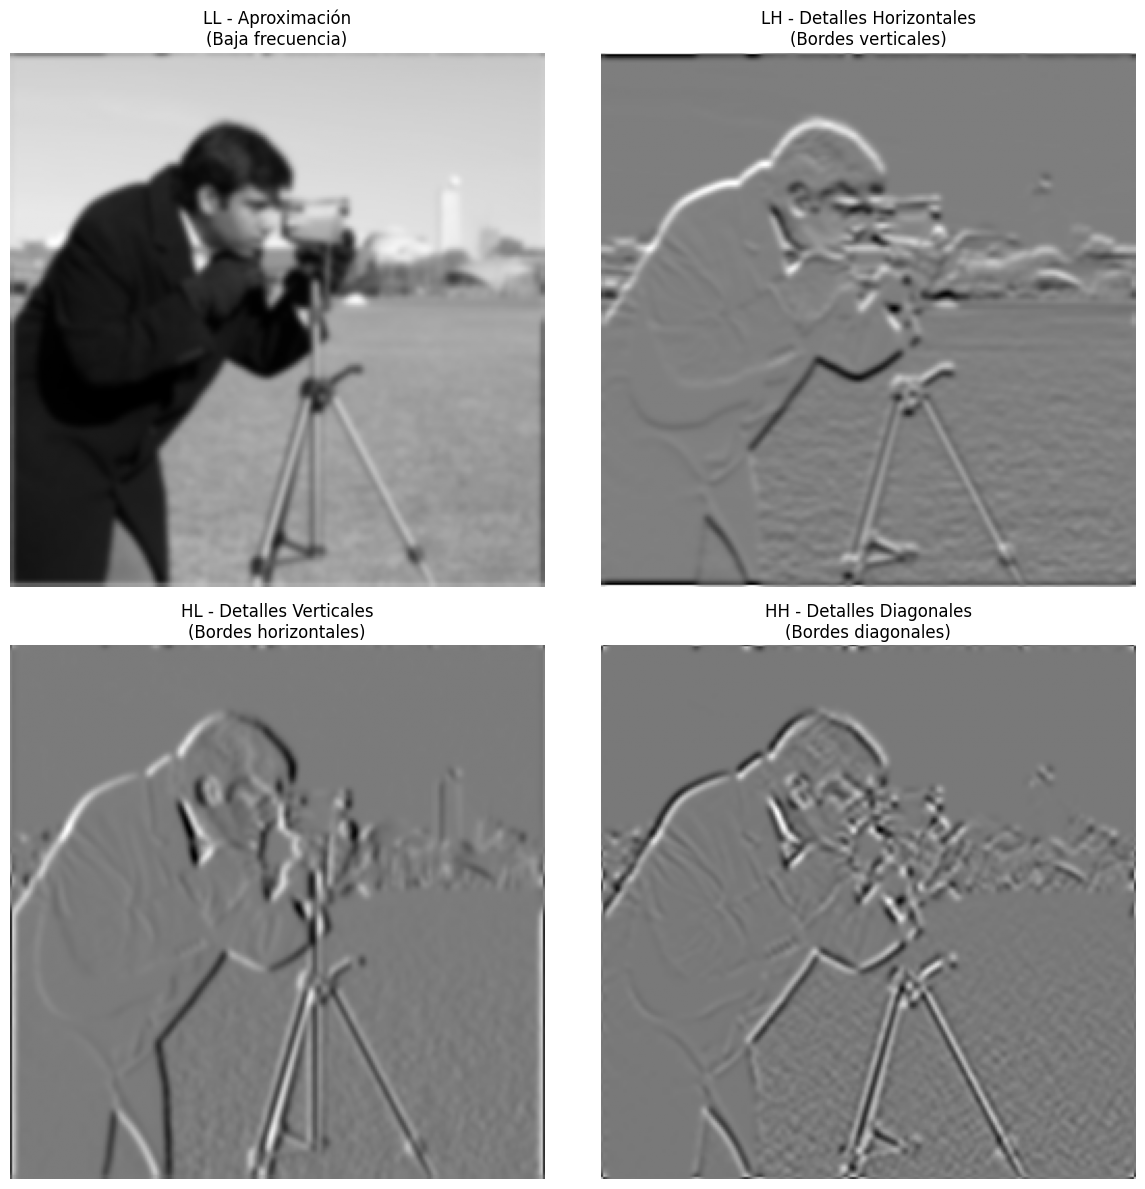

In [16]:
# 1. Transformada wavelet, con la libreria
coeffs = pywt.dwt2(blurred, wavelet='bior1.3')
LL, (LH, HL, HH) = coeffs
# Visualizar todas las componentes de la transformada wavelet
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

# LL - Aproximación (componentes de baja frecuencia)
axes[0,0].imshow(LL, cmap='gray')
axes[0,0].set_title('LL - Aproximación\n(Baja frecuencia)')
axes[0,0].axis('off')

# LH - Detalles horizontales (bordes verticales)
axes[0,1].imshow(LH, cmap='gray')
axes[0,1].set_title('LH - Detalles Horizontales\n(Bordes verticales)')
axes[0,1].axis('off')

# HL - Detalles verticales (bordes horizontales)
axes[1,0].imshow(HL, cmap='gray')
axes[1,0].set_title('HL - Detalles Verticales\n(Bordes horizontales)')
axes[1,0].axis('off')

# HH - Detalles diagonales
axes[1,1].imshow(HH, cmap='gray')
axes[1,1].set_title('HH - Detalles Diagonales\n(Bordes diagonales)')
axes[1,1].axis('off')

plt.tight_layout()
plt.show()

In [17]:
def admm_wavelet_deblur(blurred_img, kernel, original_img=None, wavelet='bior1.3', lambda_param=0.1, rho=1.0, iterations=200):
    # Función para calcular PSNR
    def calculate_psnr(img1, img2):
        mse = np.mean((img1 - img2) ** 2)
        if mse == 0:
            return 100
        max_pixel = 255.0
        psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
        return psnr

    coeffs = pywt.dwt2(blurred_img, wavelet='bior1.3')
    LL, (LH, HL, HH) = coeffs
    # Preparar el kernel en el dominio de frecuencia, estos dominios son aquellos
    # donde se aplica cada transformada, eso fue lo que entendi en un paper.
    kernel_fft = np.fft.fft2(kernel, s=blurred_img.shape)
    kernel_conj_fft = np.conjugate(kernel_fft)

    # Variables ADMM, para correr la función, también son nuestras varibles objetivo
    x = blurred_img.copy()
    z = x.copy()
    u = np.zeros_like(x)
    
    # Lista para almacenar PSNR en cada iteración
    psnr_history = []

    for i in range(iterations):
        # x-update (minimiza ||Hx - y||^2 + rho/2||x - z + u||^2)
        x_plus_u_fft = np.fft.fft2(z - u)
        numerator = kernel_conj_fft * np.fft.fft2(blurred_img) + rho * x_plus_u_fft
        denominator = np.abs(kernel_fft)**2 + rho
        x = np.real(np.fft.ifft2(numerator / denominator))

        # z-update con soft thresholding en dominio wavelet
        x_plus_u = x + u
        coeffs_x = pywt.dwt2(x_plus_u, wavelet)
        LL_x, (LH_x, HL_x, HH_x) = coeffs_x

        # Aplicar soft thresholding solo a los detalles
        LH_z = soft_threshold(LH_x, lambda_param/rho)
        HL_z = soft_threshold(HL_x, lambda_param/rho)
        HH_z = soft_threshold(HH_x, lambda_param/rho)

        # Reconstruir con coeficientes procesados
        z = pywt.idwt2((LL_x, (LH_z, HL_z, HH_z)), wavelet)

        # u-update
        u = u + (x - z)
        
        # Calcular PSNR si se proporciona la imagen original
        if original_img is not None:
            psnr = calculate_psnr(original_img, z)
            psnr_history.append(psnr)

    if original_img is not None:
        return z, psnr_history
    else:
        return z

In [18]:
# Ejecutar pipeline completo
# 1. Aplicar ADMM con soft thresholding en dominio wavelet
deblurred_admm, psnr_history = admm_wavelet_deblur(blurred, blur_kernel, original, lambda_param=0.05)


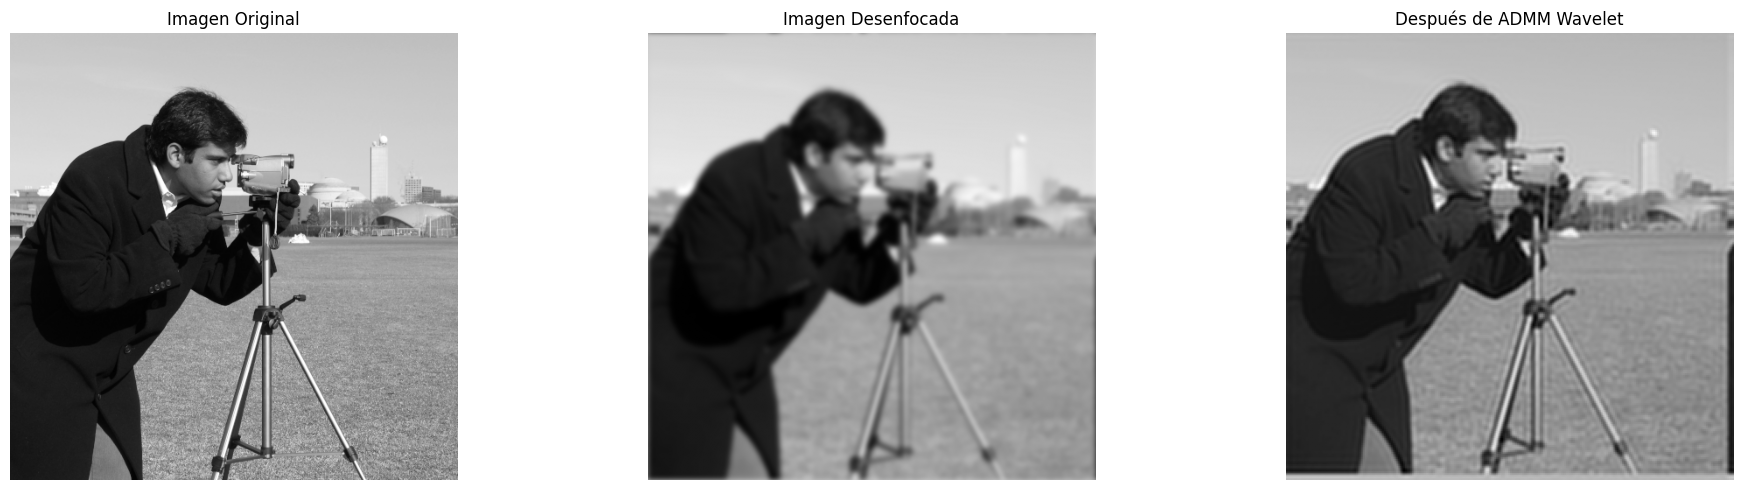

In [19]:
# Mostrar resultados
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
axes[0].imshow(original, cmap='gray')
axes[0].set_title('Imagen Original')
axes[0].axis('off')

axes[1].imshow(blurred, cmap='gray')
axes[1].set_title('Imagen Desenfocada')
axes[1].axis('off')

axes[2].imshow(deblurred_admm, cmap='gray')
axes[2].set_title('Después de ADMM Wavelet')
axes[2].axis('off')



plt.tight_layout()
plt.show()

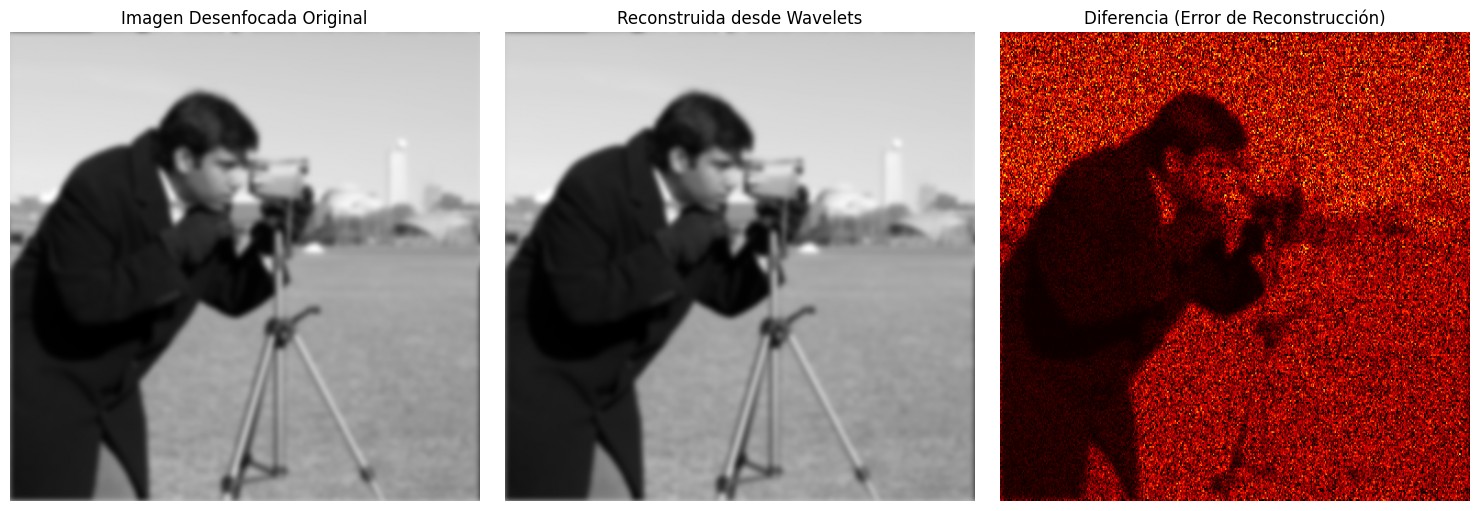

In [20]:
# También puedes mostrar la reconstrucción desde los coeficientes

reconstructed = pywt.idwt2(coeffs, wavelet='bior1.3')

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(blurred, cmap='gray')
plt.title('Imagen Desenfocada Original')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(reconstructed, cmap='gray')
plt.title('Reconstruida desde Wavelets')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(np.abs(blurred - reconstructed), cmap='hot')
plt.title('Diferencia (Error de Reconstrucción)')
plt.axis('off')

plt.tight_layout()
plt.show()

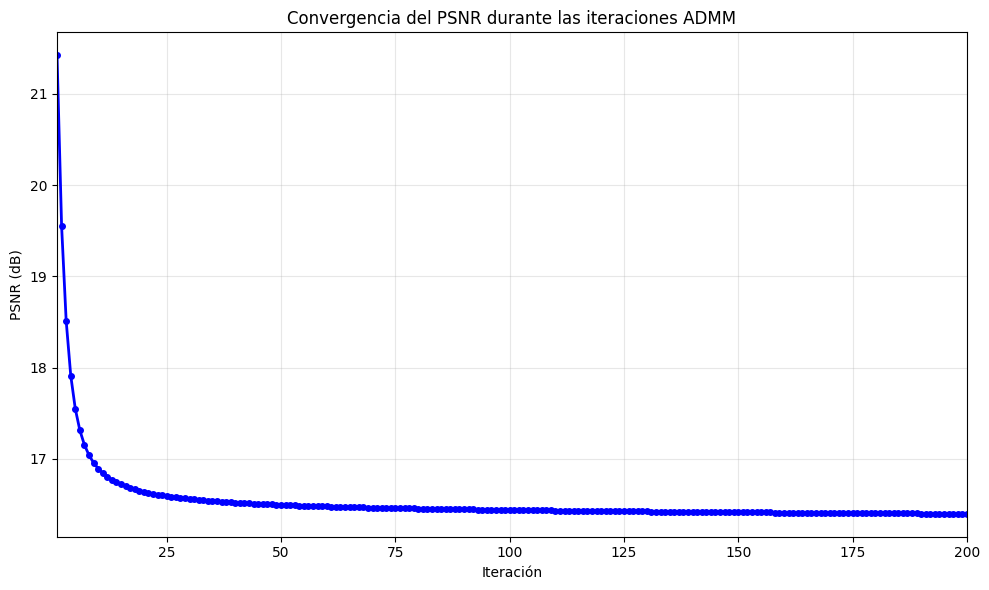

PSNR inicial: 21.42 dB
PSNR final: 16.40 dB
Mejora total: -5.02 dB


In [21]:
# Gráfica de PSNR vs Iteraciones
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(psnr_history) + 1), psnr_history, 'b-', linewidth=2, marker='o', markersize=4)
plt.xlabel('Iteración')
plt.ylabel('PSNR (dB)')
plt.title('Convergencia del PSNR durante las iteraciones ADMM')
plt.grid(True, alpha=0.3)
plt.xlim(1, len(psnr_history))
plt.tight_layout()
plt.show()

print(f'PSNR inicial: {psnr_history[0]:.2f} dB')
print(f'PSNR final: {psnr_history[-1]:.2f} dB')
print(f'Mejora total: {psnr_history[-1] - psnr_history[0]:.2f} dB')

In [24]:
# Análisis de sensibilidad del parámetro lambda
# Evaluación de diferentes valores de lambda

lambda_values = [0.001, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1.0]
final_psnr_values = []
iterations_eval = 100  # Reducir iteraciones para acelerar la evaluación

print("Evaluando diferentes valores de lambda...")
for i, lam in enumerate(lambda_values):
    print(f"Procesando lambda = {lam:.3f} ({i+1}/{len(lambda_values)})")
    
    # Ejecutar ADMM con el valor de lambda actual
    result, psnr_hist = admm_wavelet_deblur(
        blurred, blur_kernel, original, 
        lambda_param=lam, 
        iterations=iterations_eval
    )
    
    # Guardar el PSNR final
    final_psnr_values.append(psnr_hist[-1])

print("\nEvaluación completada!")

Evaluando diferentes valores de lambda...
Procesando lambda = 0.001 (1/9)
Procesando lambda = 0.005 (2/9)
Procesando lambda = 0.005 (2/9)
Procesando lambda = 0.010 (3/9)
Procesando lambda = 0.010 (3/9)
Procesando lambda = 0.020 (4/9)
Procesando lambda = 0.020 (4/9)
Procesando lambda = 0.050 (5/9)
Procesando lambda = 0.050 (5/9)
Procesando lambda = 0.100 (6/9)
Procesando lambda = 0.100 (6/9)
Procesando lambda = 0.200 (7/9)
Procesando lambda = 0.200 (7/9)
Procesando lambda = 0.500 (8/9)
Procesando lambda = 0.500 (8/9)
Procesando lambda = 1.000 (9/9)
Procesando lambda = 1.000 (9/9)

Evaluación completada!

Evaluación completada!


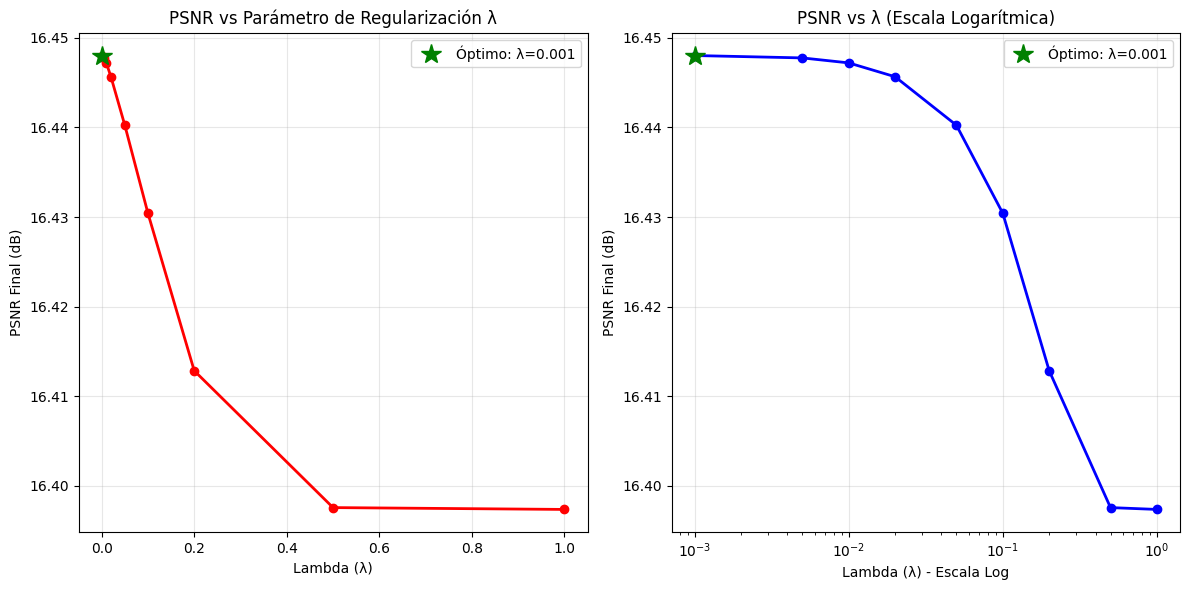


Resultados del análisis de lambda:
Valor óptimo de lambda: 0.001
PSNR máximo alcanzado: 16.45 dB

Todos los resultados:
Lambda = 0.001: PSNR = 16.45 dB
Lambda = 0.005: PSNR = 16.45 dB
Lambda = 0.010: PSNR = 16.45 dB
Lambda = 0.020: PSNR = 16.45 dB
Lambda = 0.050: PSNR = 16.44 dB
Lambda = 0.100: PSNR = 16.43 dB
Lambda = 0.200: PSNR = 16.41 dB
Lambda = 0.500: PSNR = 16.40 dB
Lambda = 1.000: PSNR = 16.40 dB


In [23]:
# Gráfica de PSNR vs Lambda
plt.figure(figsize=(12, 6))

# Subplot 1: PSNR vs Lambda (escala lineal)
plt.subplot(1, 2, 1)
plt.plot(lambda_values, final_psnr_values, 'ro-', linewidth=2, markersize=6)
plt.xlabel('Lambda (λ)')
plt.ylabel('PSNR Final (dB)')
plt.title('PSNR vs Parámetro de Regularización λ')
plt.grid(True, alpha=0.3)

# Marcar el valor óptimo
max_idx = np.argmax(final_psnr_values)
optimal_lambda = lambda_values[max_idx]
max_psnr = final_psnr_values[max_idx]
plt.plot(optimal_lambda, max_psnr, 'g*', markersize=15, label=f'Óptimo: λ={optimal_lambda:.3f}')
plt.legend()

# Subplot 2: PSNR vs Lambda (escala logarítmica)
plt.subplot(1, 2, 2)
plt.semilogx(lambda_values, final_psnr_values, 'bo-', linewidth=2, markersize=6)
plt.xlabel('Lambda (λ) - Escala Log')
plt.ylabel('PSNR Final (dB)')
plt.title('PSNR vs λ (Escala Logarítmica)')
plt.grid(True, alpha=0.3)
plt.plot(optimal_lambda, max_psnr, 'g*', markersize=15, label=f'Óptimo: λ={optimal_lambda:.3f}')
plt.legend()

plt.tight_layout()
plt.show()

print(f"\nResultados del análisis de lambda:")
print(f"Valor óptimo de lambda: {optimal_lambda:.3f}")
print(f"PSNR máximo alcanzado: {max_psnr:.2f} dB")
print(f"\nTodos los resultados:")
for lam, psnr in zip(lambda_values, final_psnr_values):
    print(f"Lambda = {lam:.3f}: PSNR = {psnr:.2f} dB")